In [1]:
import torch
from models import *
from sync_dataset import *

data = torch.load('activation_data/layer_2/0.pt')
device = torch.device("cuda:0")
seed = 114514
torch.manual_seed(seed)
np.random.seed(seed)
bs = 2048
data_path = 'activation_data/layer_2/0.pt'
dataset = CustomDataset(data_path)
train_dataset,test_dataset = random_split(dataset,[int(len(dataset)*0.9),len(dataset)-int(len(dataset)*0.9)])
test_loader = DataLoader(test_dataset, batch_size = bs, shuffle = False)
for data in test_loader:
    break
x = data.to(device).float()
topk_range = [1,100]

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
RE = []
for case in ['vae','vaep', ]:
    save_path = f"activation/activation_{case}/-10"
    encoder = torch.load(f"{save_path}/encoder.pth",weights_only = False).to(device)
    generator = torch.load(f"{save_path}/generator.pth",weights_only = False).to(device)
    loggamma = torch.load(f"{save_path}/loggamma.pth",weights_only = False).to(device)

    mean, logvar = encoder(x)
    postz = mean + torch.exp(0.5 * logvar) * torch.randn_like(mean, device=device)

    re = []
    for topk in range(*topk_range):
        topk_values, topk_indices = torch.topk(-logvar, k=topk, dim=1)
        postz_topk = torch.zeros_like(postz)
        postz_topk.scatter_(1, topk_indices, postz.gather(1, topk_indices))
        var = torch.exp(0.5 * logvar)
        xhat = generator((1-var)*postz_topk)
        re.append(torch.sum(torch.square(x - xhat), dim=1).mean().item())
    RE.append(re)
for case in ['sae','sae_log', 'sae_topk']:
    save_path = f"activation/activation_{case}"
    encoder = torch.load(f"{save_path}/encoder.pth",weights_only = False).to(device)
    generator = torch.load(f"{save_path}/generator.pth",weights_only = False).to(device)

    postz = encoder(x)

    re = []
    for topk in range(*topk_range):
        topk_values, topk_indices = torch.topk(torch.abs(postz), k=topk, dim=1)
        postz_topk = torch.zeros_like(postz)
        postz_topk.scatter_(1, topk_indices, postz.gather(1, topk_indices))
        xhat = generator(postz_topk)
        re.append(torch.sum(torch.square(x - xhat), dim=1).mean().item())
    RE.append(re)


In [6]:
RE = np.array(RE)

In [7]:
RE.shape

(5, 99)

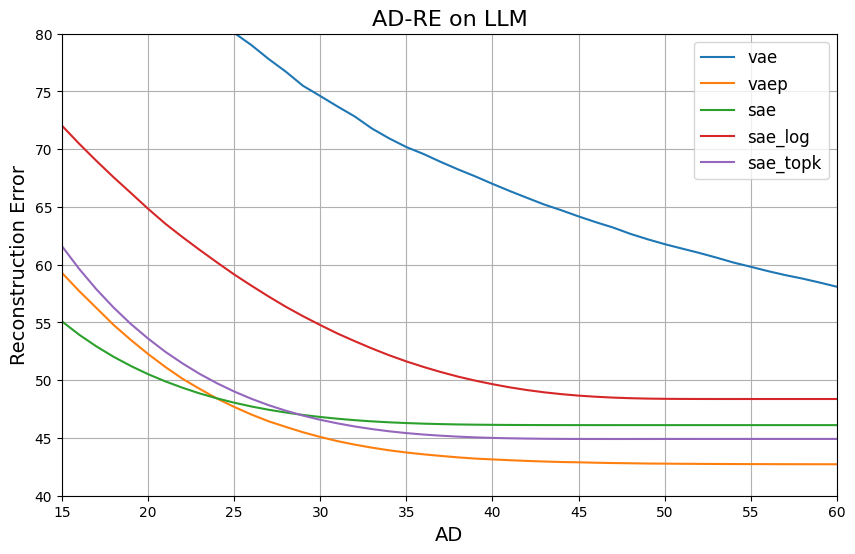

In [14]:
import matplotlib.pyplot as plt
# 绘制折线图
cases = ['vae', 'vaep', 'sae', 'sae_log', 'sae_topk']
plt.figure(figsize=(10, 6))
x = np.arange(*topk_range)
for i, re in enumerate(RE):
    plt.plot(x, re, label=cases[i])  # 绘制每个 case 的折线图

# 添加图例、标题和标签
plt.title("AD-RE on LLM", fontsize=16)
plt.xlabel("AD", fontsize=14)
plt.ylabel("Reconstruction Error", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xlim(15, 60)
plt.ylim(40, 80)

# 显示图像
plt.show()